In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import geoplot
import math
import os
from geopandas.tools import geocode
from geopandas.tools import sjoin
from shapely.geometry import LinearRing
from shapely.geometry import Point
from shapely.ops import nearest_points
          

In [2]:
#Change to data directory where district shapefiles and block shapefiles stored
data="C:/Users/Neil/Dropbox/pork spending"

In [3]:
#cd1=cd114_paoh[(cd114_paoh['CD114FP']=='12')  & (cd114_paoh['STATEFP']=='42')].boundary.iloc[0]
#closest_coords(polygon=cd1,point=PA_bgcentroids.iloc[0])
#PA_bg['cp1_x']=
#print(PA_bg.crs)
#cols=['CD1','CD2','CD3','CD4','CD5','CD6','CD7','CD8','CD9','CD10','CD11','CD12','CD13','CD14','CD15','CD16','CD17','CD18']
stfips_map={
    'AL' : ['01','Alabama'],
    'AK' : ['02','Alaska'],
    'AZ' : ['04','Arizona'],
    'AR' : ['05','Arkansas'],
    'CA' : ['06','Calafornia'],
    'CO' : ['08','Colorado'],
    'CT' : ['09','Connecticut'],
    'DE' : ['10','Delaware'],
    'FL' : ['12','Florida'],
    'GA' : ['13','Georgia'],
    'HI' : ['15','Hawaii'],
    'ID' : ['16','Idaho'],
    'IL' : ['17','Illinois'],
    'IN' : ['18','Indiana'],
    'IA' : ['19','Iowa'],
    'KS' : ['20','Kansas'],
    'KY' : ['21','Kentucky'],
    'LA' : ['22','Louisiana'],
    'ME' : ['23','Maine'],
    'MD' : ['24','Maryland'],
    'MA' : ['25','Massachusetts'],
    'MI' : ['26','Michigan'],
    'MN' : ['27','Minnesota'],
    'MS' : ['28','Mississippi'],
    'MO' : ['29','Montana'],
    'MT' : ['30','Montana'],
    'NE' : ['31','Nebraska'],
    'NV' : ['32','Nevada'],
    'NH' : ['33','New Hampshire'],
    'NJ' : ['34','New Jersey'],
    'NM' : ['35','New Mexico'],
    'NY' : ['36','New York'],
    'NC' : ['37','North Carolina'],
    'ND' : ['38','North Dakota'],
    'OH' : ['39','Ohio'],
    'OK' : ['40','Oklahoma'],
    'OR' : ['41','Oregon'],
    'PA' : ['42','Pennsylvania'],
    'RI' : ['44','Rhode Island'],
    'SC' : ['45','South Carolina'],
    'SD' : ['46','South Dakota'],
    'TN' : ['47','Tennessee'],
    'TX' : ['48','Texas'],
    'UT' : ['49','Utah'],
    'VT' : ['50','Vermont'],
    'VA' : ['51','Virginia'],
    'WA' : ['53','Washington'],
    'WV' : ['54','West Virginia'],
    'WI' : ['55','Wisconsin'],
    'WY' : ['56','Wyoming'],
    'AS' : ['60','American Samoa'],
    'GU' : ['66','Guam'],
    'MP' : ['69','Northern Mariana Islands'],
    'PR' : ['72','Puerto Rico'],
    'VI' : ['78','Virgin Islands'],
    'ALL':['','']
}

nonstates = ['AS','GU' ,'MP' ,'PR' ,'VI','ALL' ]


# Define distance between two coordinates using haversine formula. Default distance is in km.

In [4]:
def dist(coord1,coord2,r=6371.009):
    x1,y1,x2,y2 = map(math.radians, [coord1.y,coord1.x,coord2.y,coord2.x])
    sigma=np.arccos(np.sin(x1)*np.sin(x2)+np.cos(x1)*np.cos(x2)*np.cos(np.abs(y1-y2)))
    a=np.sin(np.abs(x1-x2)/2)**2+np.cos(x1)*np.cos(x2)*np.sin(np.abs(y1-y2)/2)**2
    #sigma=2*math.asin(np.sqrt(a))
    dist=sigma*r
    
    return dist
    #return x1,x2,y1,y2

# Define a function that takes a single point and single polygon and finds minimum distance

In [5]:
def mindist(coord, polygon):
    #If the polygon is truly a polygon, turn it into an iterable
    if polygon.type == 'Polygon':
        polygon=[polygon] 
    #If the polygon is a multipolygon, its already iterable. Go through each polygon,
    #turn into a linestring of the border. Then find the point on the linestring closest
    #to the coordinate you are working on.
    #Use haversine function to find spherical distance from the two points for each polygon in district.
    #Return minimum of these distances.
    borders = [LinearRing(p.exterior.coords) for p in polygon]
    d_list = [b.project(coord) for b in borders] # list of distance along LineRing with minimum distance to point
    p_list = list(map(lambda x, y: x.interpolate(y), borders , d_list))
    coord_lists = [list(p.coords)[0] for p in p_list] 
    coord_df = pd.DataFrame({'coord':coord_lists})
    coord_df['longitude']=coord_df['coord'].apply(lambda x : x[0])
    coord_df['latitude'] =coord_df['coord'].apply(lambda x: x[1]) 
    closest_point_coords=gpd.GeoDataFrame(coord_df,geometry=gpd.points_from_xy(coord_df.longitude, coord_df.latitude)) 
    dists=list(map(lambda x :dist(coord,x),closest_point_coords.geometry ))
    mindist=min(dists)
            
    return mindist


In [6]:
zcta=gpd.read_file(data + "/tl_2019_us_zcta510/tl_2019_us_zcta510.shp")
zcta.loc[:,'centroid']=zcta.geometry.centroid
zcta = zcta.set_geometry('centroid')


In [24]:
def dist_to_cd(congress,zip_centroid):

    #load the appropriate district map depending on what is passed into the congress variable
    ####################################################################################
    #TRIMMED MAPS
    distmap=gpd.read_file(data + "/trimmed_cd_shapefiles/"+congress+".shp")
    distmap=distmap.rename(columns={'STATEFP_1':'STATEFP'})
    # Make sure they're using the same projection reference        
    distmap.crs = zip_centroid.crs 
    
    print("Matching zip codes to districts: ")
    # Create dataset with zips and their district assigned by where the centriod of the zcta lies
    distmap=distmap.rename(columns={'STATEFP10':'STATEFP'})
    distmap['geometry_dist']=distmap['geometry'] # create an identical geometry column so that it is saved after join
    zip_centroid=zip_centroid.rename(columns={'geometry':'zip'})

    zips=sjoin(zip_centroid,distmap[['STATEFP','dist','geometry','geometry_dist']],how="left")
    #some zips centroids are found outside of a district (eg. index 1564). There are 42 of these. Just drop them
    zips=zips[zips.geometry_dist.notnull()] 
    zips=zips.rename(columns={'STATEFP_left':'STATEFP','dist_left':'dist'})
    distlist=list(map(lambda x,y:mindist(x,y),zips.centroid,zips.geometry_dist ))
    dist_df=pd.DataFrame({'zip_code':zips.ZCTA5CE10,'state':zips.STATEFP,'cd_centroid':zips.dist,'zip_dists':distlist})
    
    def normalize_measure(zipvars_df, measure):
        a={measure+'_mean':zipvars_df.groupby(['cd_centroid',"state"])[measure].mean(),
        measure+'_std':zipvars_df.groupby(['cd_centroid',"state"])[measure].std(),
        measure+'count':zipvars_df.groupby(['cd_centroid',"state"])[measure].count()}
        a_df=pd.DataFrame(data=a)
        zipvars_df=zipvars_df.merge(a_df,on=['cd_centroid','state'],how="inner")
        zipvars_df['z_'+measure]=(zipvars_df[measure]-zipvars_df[measure+'_mean'])/zipvars_df[measure+'_std']
        normalized_df=zipvars_df
        return normalized_df
    
    dist_df=normalize_measure(dist_df,'zip_dists')
    
    return dist_df
    

# Run distance to cd function for Congressional maps for 111, 112, 113, and 114 congresses

In [26]:
%%time
#CD111
print('Creating file for cd111')
outfile=dist_to_cd("cd111",zcta)
print('Exporting file to .csv')
outfile.to_csv(data + "/Get distance to CD/cd111_zip_dists_to_trimmedcd.csv")    
print('.csv file for cd111 created') 
    
#CD113
print('Creating file for cd113')
outfile=dist_to_cd("cd113",zcta)
print('Exporting file to .csv')
outfile.to_csv(data + "/Get distance to CD/cd113_zip_dists_to_trimmedcd.csv")    
print('.csv file for cd113 created') 

#CD112
print('Creating file for cd113')
outfile=dist_to_cd("cd112",zcta)
print('Exporting file to .csv')
outfile.to_csv(data + "/Get distance to CD/cd112_zip_dists_to_trimmedcd.csv")        
print('.csv file for cd113 created') 

#CD114
print('Creating file for cd114')
outfile=dist_to_cd("cd114",zcta)
print('Exporting file to .csv')
outfile.to_csv(data + "/Get distance to CD/cd114_zip_dists_to_trimmedcd.csv")      
print('.csv file for cd114 created') 


Creating file for cd111
Matching zip codes to districts: 
Exporting file to .csv
.csv file for cd111 created
Creating file for cd113
Matching zip codes to districts: 
Exporting file to .csv
.csv file for cd113 created
Creating file for cd113
Matching zip codes to districts: 
Exporting file to .csv
.csv file for cd113 created
Creating file for cd114
Matching zip codes to districts: 
Exporting file to .csv
.csv file for cd114 created
Wall time: 16min 55s


In [25]:
#Too slow
#%%time
#congress_seris=pd.Series(['cd111', 'cd112', 'cd113', 'cd114'])
#def dist_to_cd_wrapper(congress):
#    print('Creating file for '+congress)
#    outfile=dist_to_cd(congress,zcta)
#    print('Exporting file to .csv')
#    outfile.to_csv(data + "/Get distance to CD"+congress+"_zip_dists_to_trimmedcd.csv")    
#    print('.csv file for '+congress+' created') 

#congress_seris.apply(dist_to_cd_wrapper)

Creating file for cd111
Matching zip codes to districts: 
Exporting file to .csv
.csv file for cd111 created
Creating file for cd112
Matching zip codes to districts: 
Exporting file to .csv
.csv file for cd112 created
Creating file for cd113
Matching zip codes to districts: 
Exporting file to .csv
.csv file for cd113 created
Creating file for cd114
Matching zip codes to districts: 
Exporting file to .csv
.csv file for cd114 created
Wall time: 27min 19s


# Read in distance files and make maps

In [9]:
cd111_zipdists=pd.read_csv(data + "/Get distance to CD/cd111_zip_dists_to_trimmedcd.csv")
cd112_zipdists=pd.read_csv(data + "/Get distance to CD/cd112_zip_dists_to_trimmedcd.csv")
cd113_zipdists=pd.read_csv(data + "/Get distance to CD/cd113_zip_dists_to_trimmedcd.csv")
cd114_zipdists=pd.read_csv(data + "/Get distance to CD/cd114_zip_dists_to_trimmedcd.csv")

file_dict={'cd111':cd111_zipdists,
           'cd112':cd112_zipdists,
           'cd113':cd113_zipdists,
           'cd114':cd114_zipdists}

# Make normalized measure

In [10]:
def normalize_measure(congress, measure):
    zipvars=file_dict[congress]

    a={'dist_mean':zipvars.groupby(['cd_centroid',"state"])[measure].mean(),
        'dist_std':zipvars.groupby(['cd_centroid',"state"])[measure].std(),
        'count':zipvars.groupby(['cd_centroid',"state"])[measure].count()}
    #print("made it here 1")
    a_df=pd.DataFrame(data=a)
    #print("made it here 2")
    zipvars=zipvars.merge(a_df,on=['cd_centroid','state'],how="inner")
    #print("made it here 3")
    zipvars['z_ziptocddistance']=(zipvars[measure]-zipvars['dist_mean'])/zipvars['dist_std']
   # print("made it here 4")    
    return zipvars

#save as original names. This code adds colomns, so it will throw error if run more than once
#normalize_measure('cd111', 'zip_dist').to_csv(data + "/Get average distance/cd111_avezip_dists_to_bgs.csv")
#normalize_measure('cd112', 'zip_dist').to_csv(data + "/Get average distance/cd112_avezip_dists_to_bgs.csv")
#normalize_measure('cd113', 'zip_dist').to_csv(data + "/Get average distance/cd113_avezip_dists_to_bgs.csv")
#normalize_measure('cd114', 'zip_dist').to_csv(data + "/Get average distance/cd114_avezip_dists_to_bgs.csv")
file_dict['cd111']=normalize_measure('cd111', 'zip_dists')
file_dict['cd112']=normalize_measure('cd112', 'zip_dists')
file_dict['cd113']=normalize_measure('cd113', 'zip_dists')
file_dict['cd114']=normalize_measure('cd114', 'zip_dists')



In [11]:
import matplotlib.pyplot as plt

In [12]:
def plot_outcome_vars(variable='zip_dists',state='ALL', congress='cd111', notes=''):
    # #set variable to visualize
    #variable= popover18wav, avebgdist, z_dist, zip_dist
    if variable in ['zip_dists','z_ziptocddistance' ]:
        zipvars=file_dict[congress]
    else:
        zipvars=pd.read_csv(data + "/Get average distance/"+congress + "_avezip_dists_to_bgs.csv") #change here depending on which congress we want to look at
    print('Vars in zipvars:')

    if 'state' in list(zipvars.columns.values):
        zipvars=zipvars.rename(columns={'state':'st'})
    if 'zip_code' in list(zipvars.columns.values):
        zipvars=zipvars.rename(columns={'zip_code':'zip'})
    if 'cd_centroid' in list(zipvars.columns.values):
        zipvars=zipvars.rename(columns={'cd_centroid':'dist'})
    print(zipvars[variable].describe())

    #get congressional district shapefile
    #TRIMMED MAPS
    distmap=gpd.read_file(data + "/trimmed_cd_shapefiles/"+congress+".shp")
    distmap=distmap.rename(columns={'STATEFP_1':'STATEFP'})

    distmap=distmap[distmap['dist']!='ZZ'] #get rid of "undefined" cds
    if state!='ALL':
        distmap=distmap[distmap['STATEFP']==stfips_map[state][0]] 
        zipvars=zipvars[zipvars['st']==int(stfips_map[state][0])]
    if state=='ALL':
        distmap=distmap[(distmap['STATEFP']!=int(stfips_map['AK'][0])) & (distmap['STATEFP']!=int(stfips_map['HI'][0]))] 
        zipvars=zipvars[(zipvars['st']!=int(stfips_map['AK'][0])) & (zipvars['st']!=int(stfips_map['HI'][0]))]
        
    zcta.ZCTA5CE10=zcta.ZCTA5CE10.astype(int)
    zipvars.zip=zipvars.zip.astype(int)
    zipmap=zcta.merge(zipvars,left_on='ZCTA5CE10',right_on='zip', how='right')
    zipmap=zipmap.set_geometry('geometry')
    #zipmap.plot()

    #print(distmap.head())
    zipvars.dist=zipvars.dist.astype(int)
    zipvars.st=zipvars.st.astype(int)
    distmap.dist=distmap.dist.astype(int)
    distmap.STATEFP=distmap.STATEFP.astype(int)

    distmap=distmap.merge(zipvars,left_on=['STATEFP','dist'],right_on=['st','dist'], how='inner')
    distmap = distmap.drop_duplicates(subset=["st","dist"])
    distmap=distmap.set_geometry('geometry')
    zipmap=zipmap.set_geometry('geometry')
    # set the range for the choropleth. May need to adjust
    vmin, vmax = -3, 3

    print("Creating plot")
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(20, 12)) #not sure how this works...

    # create map
    zipmap.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
    distmap.plot(ax=ax, facecolor='none',linewidth=2,edgecolor='green',alpha=1)
    #for poly in distmap['geometry']:
    #    poly.plot(ax, facecolor='white')
    #plt.show()
    #zipmap.plot(ax=ax)

    # remove the axis
    ax.axis('off')
    # add a title
    vardesc_map={'zip_dists':'Distance to district border',
                 'z_ziptocddistance': 'Distance to district border, normalized within district',
                 'popover18wav':'Average distance/population to block groups within district',
                 'avebgdist':'Average distance to block groups within district',
                 'z_dist':'Average distance to block groups within district, normalized within district' }
    title = vardesc_map[variable] + ': ' + stfips_map[state][1]
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})

    # create an annotation 
    ax.annotate(notes,xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
        
    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    cbar = fig.colorbar(sm)    
    return plt.show()
        

Vars in zipvars:
count    32830.000000
mean        17.384018
std         26.057374
min          0.000000
25%          3.379319
50%          8.896652
75%         21.327668
max        471.807191
Name: zip_dists, dtype: float64
Creating plot


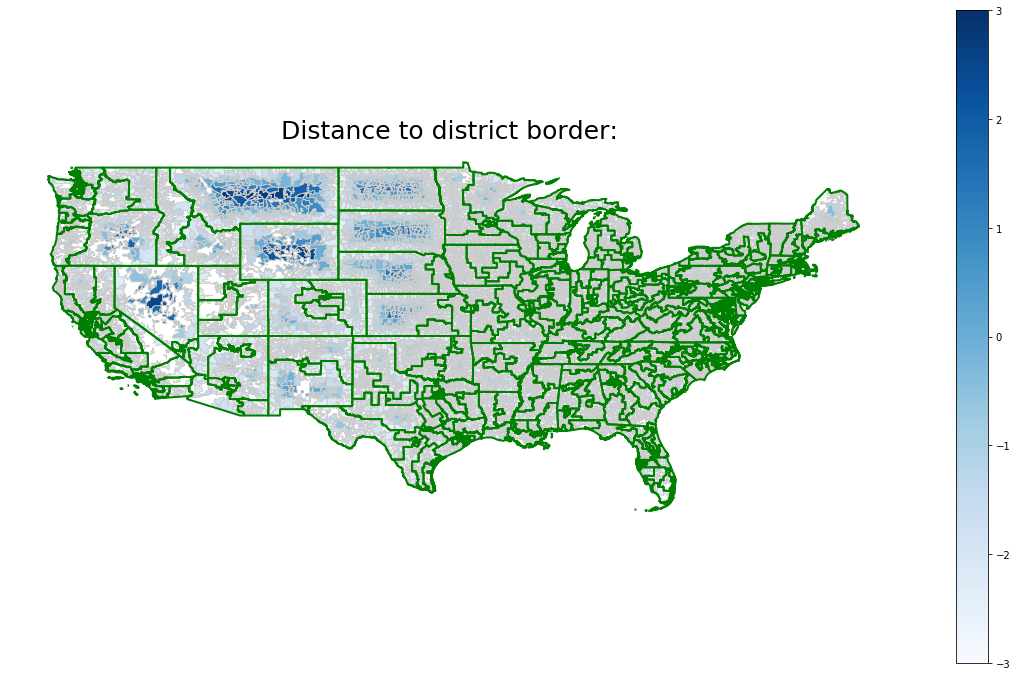

In [13]:
plot_outcome_vars()

Vars in zipvars:
count    3.283000e+04
mean     3.450044e-17
std      9.933680e-01
min     -2.115713e+00
25%     -8.025717e-01
50%     -2.353669e-01
75%      6.458132e-01
max      4.494692e+00
Name: z_ziptocddistance, dtype: float64
Creating plot


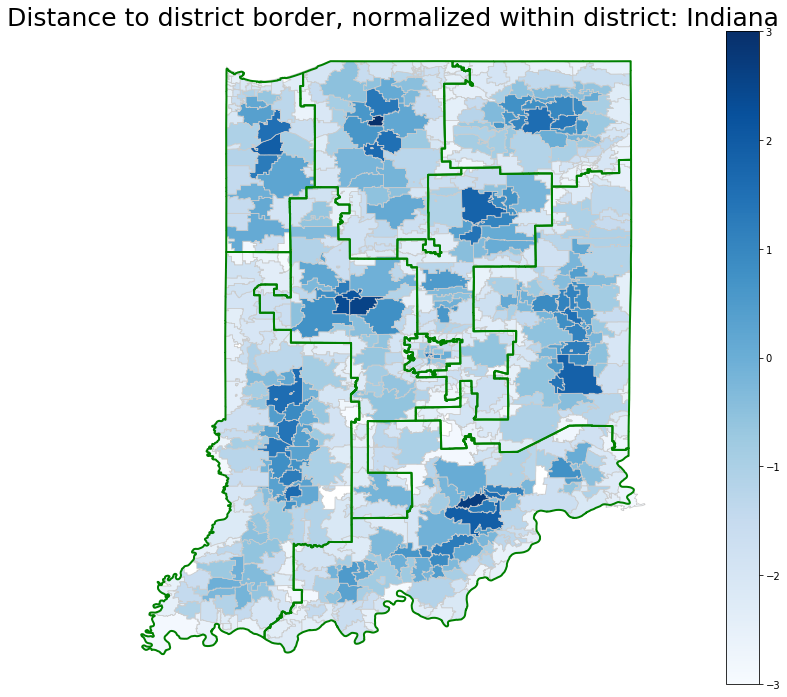

In [14]:
plot_outcome_vars(state="IN", variable='z_ziptocddistance')